# Cogvis on MNIST

In this short tutorial, we demonstrate how to use the `cogvis` API for neural network-based image classification on the MNIST dataset. Before we get started, you will need to install `cogvis`. If it's not available on PyPI or Anaconda's package repository, you can grab the wheel off our [Github page](https://github.com/TimothySimons/CVS_framework) or build from source.

In [1]:
!pip install /content/cogvis-0.0.1-py3-none-any.whl

Processing ./cogvis-0.0.1-py3-none-any.whl


You will need the following imports for this tutorial.

In [13]:
import copy
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
from torch.optim import lr_scheduler
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
# and most importantly...
from cogvis.classification import nn_classifier

...and a random seed...

In [11]:
SEED = 1234

random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

## MLP  

First things first, we need to grab the MNIST dataset. This can be downloaded using the `torchvision.datasets` package. Since we are getting the images from PyTorch instead of a local repo, we will also be using PyTorch to initialise each `DataLoader`. To see how we can use config to initialise these data loaders, see the next section *Cogvis on Hymenoptera*.



In [17]:
ROOT = '.data'
train_data = datasets.MNIST(root = ROOT, train = True, download = True)
mean = train_data.data.float().mean() / 255
std = train_data.data.float().std() / 255 

train_transforms = transforms.Compose([
    transforms.RandomRotation(5, fill=(0,)),
    transforms.RandomCrop(28, padding = 2),
    transforms.ToTensor(),
    transforms.Normalize(mean = [mean], std = [std])
    ])

valid_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean = [mean], std = [std])
    ])

train_data = datasets.MNIST(root = ROOT, 
        train = True, 
        download = True, 
        transform = train_transforms)

VALID_RATIO = 0.9
train_size = int(len(train_data) * VALID_RATIO)
val_size = len(train_data) - train_size
train_data, valid_data = data.random_split(train_data, [train_size, val_size])
valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = valid_transforms

BATCH_SIZE = 64 
train_loader = data.DataLoader(train_data, shuffle = True, batch_size = BATCH_SIZE)
val_loader = data.DataLoader(valid_data, batch_size = BATCH_SIZE)

Now that we have our data loaders initialised, we can instantiate and train our model. The input size is 28*28=784 and the output size is 10 with hidden layers being 250 and 100 respectively. Since MLPs can't handle multi-dimensional data, all images (whether 2D or 3D) are flattened to a 1D vector.

In [18]:
mlp_model = nn_classifier.MLP([784, 250, 100, 10])   
optimizer = optim.Adam(mlp_model.parameters())
criterion = nn.CrossEntropyLoss()
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# and the coup de grâce of the nn_classifier module...
model = nn_classifier.train(mlp_model, train_loader, val_loader, train_size, 
                            val_size, criterion, optimizer, exp_lr_scheduler, 
                            num_epochs=10)

Epoch: 0/9
----------
train Loss: 1.6633 Acc: 0.8100
val Loss: 1.5264 Acc: 0.9388

Epoch: 1/9
----------
train Loss: 1.5414 Acc: 0.9231
val Loss: 1.5134 Acc: 0.9492

Epoch: 2/9
----------
train Loss: 1.5247 Acc: 0.9387
val Loss: 1.5077 Acc: 0.9553

Epoch: 3/9
----------
train Loss: 1.5190 Acc: 0.9438
val Loss: 1.5087 Acc: 0.9538

Epoch: 4/9
----------
train Loss: 1.5151 Acc: 0.9471
val Loss: 1.4945 Acc: 0.9675

Epoch: 5/9
----------
train Loss: 1.5090 Acc: 0.9528
val Loss: 1.4930 Acc: 0.9682

Epoch: 6/9
----------
train Loss: 1.5079 Acc: 0.9541
val Loss: 1.4916 Acc: 0.9700

Epoch: 7/9
----------
train Loss: 1.4975 Acc: 0.9642
val Loss: 1.4863 Acc: 0.9757

Epoch: 8/9
----------
train Loss: 1.4941 Acc: 0.9673
val Loss: 1.4850 Acc: 0.9762

Epoch: 9/9
----------
train Loss: 1.4927 Acc: 0.9687
val Loss: 1.4839 Acc: 0.9777

Best val Acc: 0.977667


There we have it, an MLP classification model that achieves validation accuracy of 0.9777 on the MNIST dataset when trained for 10 epochs with a batch size of 64.


---
*Note to developers*:
* Sould the PyTorch objects be instantiated by the users or made parameters (e.g. `nn_classifier.train(..., optimizer='Adam')`) instead?
* A big design decision is whether we want to completely hide PyTorch or work in tandem with it. What are your thoughts on this?


## CNN
Now let's use cogvis' CNN implementation on the MNIST dataset. The only change we need to make is to make is to create a CNN model and reinstantiate the optimizer with the new model's trainable parameters. We can use the same evaluation criterion and learning rate schedular as the previous model (though may not be the best decision from a ML perspective).

The implemented architecture is the one described on [wikipedia](https://https://en.wikipedia.org/wiki/Convolutional_neural_network) as the "typical CNN architecture".  

 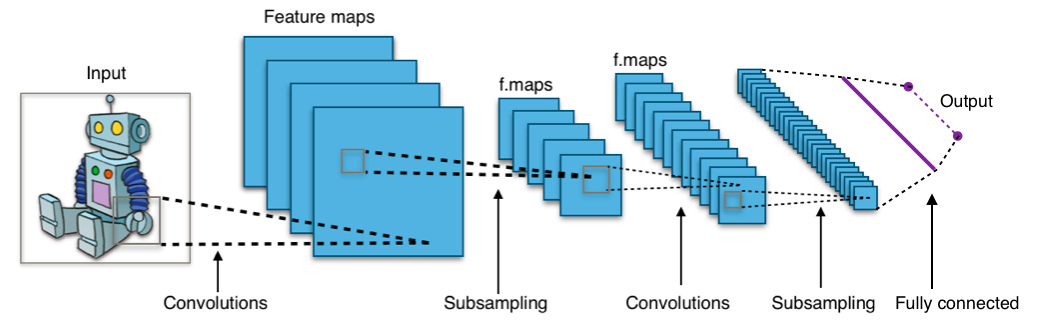

The `cogvis` implmentation allows you to perform any number of convolutions + subsampling operations followed by a series (fully connected) feed-forward operations. 

In the example below, the first convolutional layer has 6 filters. The image is then subsampled and passed to a convolutional layer with 16 filters. Images are subsampled after each convolution with a kernel size of `pool_ks`. We then calculate the flattened result and pass this to the feed-forward part of the network.

---
*Note to developers:*  
* Should I make the CNN model more customisable (keeping in mind that the user can load a whole slew of other PyTorch models - see next section)?



In [21]:
cnn_model = nn_classifier.CNN([1, 6, 16], [256, 120, 84, 10], conv_ks=5, pool_ks=2)
optimizer = optim.Adam(cnn_model.parameters())

cnn_model = nn_classifier.train(cnn_model, train_loader, val_loader, train_size, 
                            val_size, criterion, optimizer, exp_lr_scheduler, 
                            num_epochs=10)

Epoch: 0/9
----------
train Loss: 1.6399 Acc: 0.8280
val Loss: 1.5041 Acc: 0.9578

Epoch: 1/9
----------
train Loss: 1.5222 Acc: 0.9405
val Loss: 1.4921 Acc: 0.9707

Epoch: 2/9
----------
train Loss: 1.5090 Acc: 0.9530
val Loss: 1.4976 Acc: 0.9633

Epoch: 3/9
----------
train Loss: 1.5049 Acc: 0.9561
val Loss: 1.4920 Acc: 0.9690

Epoch: 4/9
----------
train Loss: 1.5035 Acc: 0.9577
val Loss: 1.4890 Acc: 0.9722

Epoch: 5/9
----------
train Loss: 1.5007 Acc: 0.9605
val Loss: 1.4835 Acc: 0.9775

Epoch: 6/9
----------
train Loss: 1.4978 Acc: 0.9635
val Loss: 1.4857 Acc: 0.9755

Epoch: 7/9
----------
train Loss: 1.4969 Acc: 0.9641
val Loss: 1.4849 Acc: 0.9762

Epoch: 8/9
----------
train Loss: 1.4985 Acc: 0.9626
val Loss: 1.4826 Acc: 0.9795

Epoch: 9/9
----------
train Loss: 1.4950 Acc: 0.9661
val Loss: 1.4848 Acc: 0.9767

Best val Acc: 0.979500


# Cogvis on Hymenoptera

Here, we are going to look at a classification example that uses 3D images. We are attempting to classify images as ants or bees.  

In the below code snippet, we see how the `nn_classifier` module can be used to construct the data transforms and data loaders. The `data_loader` function assumes the images are stored in the following directory structure.

```
train/
├── class_0/
|   ├── 001.jpg
|   ├── 002.jpg
|   └── 003.jpg
├── class_1/
|   ├── 004.jpg
|   └── 005.jpg
└── etc.
```


---  
  
*Note to developers*:
* This single method of fetching a data loader is quite limiting; it assumes your images are stored in folders with a specific directory structure. By inheriting the `torch.utils.data.Dataset` class (or one of its subclasses) we can stream images from any number of sources (video feed, server, etc.). Doing this in a general way is no measly task and comes with a whole slew of considerations. It might be best to leave doing this for a later date.

In [27]:
train_transform = nn_classifier.data_transform(
    Resize = (256,),
    CenterCrop= (224,),
    ToTensor = (),
    Normalize = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
)

val_transform = nn_classifier.data_transform(
    Resize = (256,),
    CenterCrop = (224,),
    ToTensor = (), 
    Normalize = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
)

train_dir = '/content/drive/My Drive/hymenoptera_data/train/'
val_dir = '/content/drive/My Drive/hymenoptera_data/val/'
train_size, train_loader = nn_classifier.data_loader(train_dir, 4, train_transform)
val_size, val_loader = nn_classifier.data_loader(val_dir, 4, val_transform)

According to PyTorch,  

"*In practice, very few people train an entire Convolutional Network from scratch (with random initialization), because it is relatively rare to have a dataset of sufficient size.*"

So here, we are only looking at a dataset with 244 training images and 153 validation images (so expect terrible accuracy) to mitigate the stress of waiting many compute hours for the model to train.

With two (highly improvised) architecures for MLP and CNN, we get validation accuracies of 0.5948 and 0.6209 respectively. `resnet18` performs only slightly better with an accuracy of 0.6797. If we instead use a pretrained model, we can achieve an accuracy of 0.9346 (after only 5 epochs). 

If we look at the [documentation](https://pytorch.org/docs/stable/torchvision/models.html#classification), we see that `resnet18` was trained on [imagenet](https://http://image-net.org/). `cogvis.nn_classifier` modifies the final layer of this model to produce outputs for 2 classes (ants & bees - which is a subset of imagenet). The model is then trained for these two classes.



In [33]:
    #nn_model = nn_classifier.MLP([150528, 250, 2])
    #nn_model = nn_classifier.CNN([3, 6, 16], [16 * 53 * 53, 120, 84, 2], conv_ks=5, pool_ks=2)
    #nn_model = nn_classifier.existing_model('resnet18', 2)
    nn_model = nn_classifier.existing_model('resnet18', 2, pretrained=True)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(nn_model.parameters(), lr=0.001, momentum=0.9)
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
    nn_model = nn_classifier.train(
            nn_model, 
            train_loader, val_loader, 
            train_size, val_size, 
            criterion, 
            optimizer,
            exp_lr_scheduler, 
            num_epochs=5
            )


Epoch: 0/4
----------
train Loss: 0.4866 Acc: 0.7500
val Loss: 0.2389 Acc: 0.8954

Epoch: 1/4
----------
train Loss: 0.5290 Acc: 0.8115
val Loss: 0.5666 Acc: 0.7778

Epoch: 2/4
----------
train Loss: 0.3286 Acc: 0.8770
val Loss: 0.2750 Acc: 0.9346

Epoch: 3/4
----------
train Loss: 0.5754 Acc: 0.7992
val Loss: 0.5665 Acc: 0.8301

Epoch: 4/4
----------
train Loss: 0.3654 Acc: 0.8770
val Loss: 0.3435 Acc: 0.8431

Best val Acc: 0.934641
